This code will taKe the models trained on gpp and reco and predict each of them.  It will then derive nee using the equation reco-gpp and then 
compare the observed nee vs predicted for R2, RMSE, MAE and also plot the observed vs predicted by site like usual

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Suppress warnings
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)


# 1. Load your dataset
file_path = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_alt_soil_lc_co2.csv"
df = pd.read_csv(file_path)

df = df[df['flux_method'] == 'EC']

# 2. Create tmean_C and date
df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# 3. Define predictors and target variables
feature_cols = [
    'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
    'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs',
    'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm',
    'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm',
    'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT',
    'land_cover', 'month' # Categorical features
]
categorical_features = ['land_cover', 'month']

# Drop rows where key validation targets ('nee') or identifiers are missing.
# We need 'nee' from the dataframe to compare against our derived NEE.
# CatBoost itself can handle missing values in predictor (feature) columns.
df = df.dropna(subset=['site_reference', 'nee'])

# Ensure categorical features are strings for CatBoost prediction consistency
for col in categorical_features:
    df[col] = df[col].astype(str)

# Define output path for figures and create it
out_path = os.path.join("/explore/nobackup/people/spotter5/anna_v/v2/derived_nee_validation")
os.makedirs(out_path, exist_ok=True)
figures_path = os.path.join(out_path, "figures")
os.makedirs(figures_path, exist_ok=True)

# --- Model Prediction and Derivation ---

# Define model paths
gpp_model_path = '/explore/nobackup/people/spotter5/anna_v/v2/models/gpp.json'
# NOTE: The request is to calculate NEE using Reco - GPP. This requires a Reco model.
# We assume the provided 'nee_model' path actually points to a model for Reco (Ecosystem Respiration).
reco_model_path = '/explore/nobackup/people/spotter5/anna_v/v2/models/nee.json'

# Load the pre-trained models
print("Loading GPP and Reco models...")
gpp_model = CatBoostRegressor()
gpp_model.load_model(gpp_model_path)

reco_model = CatBoostRegressor()
reco_model.load_model(reco_model_path)
print("Models loaded successfully.")

# Prepare the feature set for prediction
X_pred = df[feature_cols]

# Predict GPP and Reco using the loaded models
print("Predicting GPP and Reco values...")
df['gpp_pred'] = gpp_model.predict(X_pred)
df['reco_pred'] = reco_model.predict(X_pred) # Assuming this is predicting Reco
print("Predictions complete.")

# Calculate derived NEE using the standard ecological equation: NEE = Reco - GPP
print("Calculating derived NEE...")
# df['nee_derived'] = df['reco_pred'] - df['gpp_pred']
df['nee_derived'] = df['gpp_pred'] - df['reco_pred'] 

# --- Validation and Plotting ---

# Prepare data for comparison by dropping any rows where comparison is not possible
comparison_df = df[['nee', 'nee_derived']].dropna()

# Calculate validation metrics
observed_nee = comparison_df['nee']
derived_nee = comparison_df['nee_derived']

r2 = r2_score(observed_nee, derived_nee)
rmse = np.sqrt(mean_squared_error(observed_nee, derived_nee))
mae = mean_absolute_error(observed_nee, derived_nee)

print("\n--- Validation Metrics ---")
print(f"Derived NEE vs. Observed NEE:")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Create the density plot
print("\nGenerating density plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Use a hexbin plot for visualizing density, which is effective for large datasets
hb = ax.hexbin(
    x=observed_nee, 
    y=derived_nee, 
    gridsize=100, 
    cmap='viridis', 
    mincnt=1 # Exclude bins with no data points
)

# Add a color bar to show point density
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Point Density')

# Add a 1:1 reference line
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1]),
]
ax.plot(lims, lims, 'r--', alpha=0.8, zorder=10, label='1:1 Line')

# Set labels and title
ax.set_xlabel('Observed NEE (from dataframe)', fontsize=12)
ax.set_ylabel('Derived NEE ($Reco_{pred} - GPP_{pred}$)', fontsize=12)
ax.set_title('Density Plot of Derived vs. Observed NEE', fontsize=16, pad=15)
ax.legend(loc='upper left')

# Ensure the plot has an equal aspect ratio
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Create the text string for the metrics
stats_text = (
    f"$R^2 = {r2:.3f}$\n"
    f"RMSE = {rmse:.3f}\n"
    f"MAE = {mae:.3f}"
)

# Add the metrics as a text box in the lower-right corner
ax.text(0.95, 0.05, stats_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='bottom', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))

# Save the figure to the specified path
figure_filepath = os.path.join(figures_path, "derived_vs_observed_nee_density_plot.png")
# plt.savefig(figure_filepath, dpi=300, bbox_inches='tight')
print(f"Plot successfully saved to: {figure_filepath}")

# Display the plot
plt.show()

Loading GPP and Reco models...
Models loaded successfully.
Predicting GPP and Reco values...


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature lai is present in model but not in pool.

now plot derived vs predicted

In [8]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 1. SETUP AND DATA LOADING ---

# Suppress warnings for cleaner output
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

# Load the dataset
file_path = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_alt_soil_lc_co2.csv"
df = pd.read_csv(file_path)

# Filter for EC flux method and perform initial feature engineering
df = df[df['flux_method'] == 'EC']
df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Define feature columns and categorical features
feature_cols = [
    'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
    'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs',
    'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm',
    'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm',
    'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT',
    'land_cover', 'month' # Categorical features
]
categorical_features = ['land_cover', 'month']

# Drop rows where observed NEE (our validation target) is missing
df = df.dropna(subset=['site_reference', 'nee'])

# Ensure categorical features are strings for CatBoost prediction consistency
for col in categorical_features:
    df[col] = df[col].astype(str)

# Define output paths for results
out_path = "/explore/nobackup/people/spotter5/anna_v/v2/site_specific_derived_nee"
os.makedirs(out_path, exist_ok=True)
figures_path = os.path.join(out_path, "figures")
os.makedirs(figures_path, exist_ok=True)

# --- 2. LOAD PRE-TRAINED MODELS ---

# Define model paths
gpp_model_path = '/explore/nobackup/people/spotter5/anna_v/v2/models/gpp.json'
# NOTE: To derive NEE = Reco - GPP, we need a Reco model.
# We assume the 'nee.json' file is a model trained for Reco (Ecosystem Respiration).
reco_model_path = '/explore/nobackup/people/spotter5/anna_v/v2/models/nee.json'

print("Loading GPP and Reco models...")
gpp_model = CatBoostRegressor()
gpp_model.load_model(gpp_model_path)

reco_model = CatBoostRegressor()
reco_model.load_model(reco_model_path)
print("Models loaded successfully.")


# --- 3. PROCESS EACH SITE ---

# Get a unique list of sites to iterate over
sites = df["site_reference"].unique()

# Initialize lists to store results from each site
site_metrics_list = []
all_predictions_list = []

print(f"\nProcessing {len(sites)} sites...")
for site in sites:
    print(f"  - Site: {site}")
    
    # Isolate data for the current site
    site_df = df[df["site_reference"] == site].copy()
    
    if site_df.empty:
        print(f"    ...skipping, no data.")
        continue

    # Prepare features and observed data for this site
    X_site = site_df[feature_cols]
    observed_nee = site_df['nee']
    dates_site = site_df['date']

    # Predict GPP and Reco for the site
    gpp_pred = gpp_model.predict(X_site)
    reco_pred = reco_model.predict(X_site)
    
    # Derive NEE from the predictions
    derived_nee = reco_pred - gpp_pred
    
    # Calculate performance metrics for the site
    rmse = np.sqrt(mean_squared_error(observed_nee, derived_nee))
    r2 = r2_score(observed_nee, derived_nee)
    mae = mean_absolute_error(observed_nee, derived_nee)
    
    # Store site-specific metrics
    site_metrics_list.append({
        "Site": site,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })
    
    # Store detailed predictions for the site
    predictions_df = pd.DataFrame({
        "Site": site,
        "Date": dates_site,
        "Observed_NEE": observed_nee,
        "Derived_NEE": derived_nee,
        "GPP_pred": gpp_pred,
        "Reco_pred": reco_pred
    })
    all_predictions_list.append(predictions_df)

    # --- Plotting for the site ---
    fig, ax = plt.subplots(figsize=(14, 7))
    
    plot_df = predictions_df.sort_values("Date")
    ax.plot(plot_df["Date"], plot_df["Observed_NEE"], label="Observed NEE", marker="o", linestyle='-', markersize=4, color='black')
    ax.plot(plot_df["Date"], plot_df["Derived_NEE"], label="Derived NEE ($Reco_{pred} - GPP_{pred}$)", marker="x", linestyle='--', markersize=4, color='red')
    
    ax.set_title(f"Observed vs. Derived NEE for Site: {site}", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("NEE ($gC/m^2/day$)", fontsize=12)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    fig.autofmt_xdate()

    # Add metrics text to the plot
    textstr = f"$R^2 = {r2:.2f}$\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}"
    ax.text(0.98, 0.02, textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Save the figure
    plot_filename = f'derived_nee_timeseries_{site}.png'
    plot_path = os.path.join(figures_path, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

print(f"\nAll site plots have been saved to: {figures_path}")

# --- 4. AGGREGATE RESULTS AND SAVE ---

# Combine results from all sites into single DataFrames
all_sites_metrics_df = pd.DataFrame(site_metrics_list)
all_sites_predictions_df = pd.concat(all_predictions_list, ignore_index=True)

# Save the aggregated data to CSV files
metrics_csv_path = os.path.join(out_path, 'site_specific_metrics_derived_nee.csv')
predictions_csv_path = os.path.join(out_path, 'all_sites_predictions_derived_nee.csv')
all_sites_metrics_df.to_csv(metrics_csv_path, index=False)
all_sites_predictions_df.to_csv(predictions_csv_path, index=False)

print(f"\nSite-specific metrics saved to: {metrics_csv_path}")
print(f"All predictions saved to: {predictions_csv_path}")

# --- 5. FINAL SUMMARY METRICS ---

# Pooled metrics across all data points
pooled_rmse = np.sqrt(mean_squared_error(all_sites_predictions_df["Observed_NEE"], all_sites_predictions_df["Derived_NEE"]))
pooled_r2 = r2_score(all_sites_predictions_df["Observed_NEE"], all_sites_predictions_df["Derived_NEE"])
pooled_mae = mean_absolute_error(all_sites_predictions_df["Observed_NEE"], all_sites_predictions_df["Derived_NEE"])

# Median metrics across all sites
median_rmse = all_sites_metrics_df["RMSE"].median()
median_mae = all_sites_metrics_df["MAE"].median()
median_r2 = all_sites_metrics_df["R2"].median()

print("\n--- Site-Specific Metrics ---")
print(all_sites_metrics_df.round(4))

print("\n--- Pooled Metrics (across all predictions) ---")
print(f"Pooled RMSE: {pooled_rmse:.4f}")
print(f"Pooled MAE:  {pooled_mae:.4f}")
print(f"Pooled R²:   {pooled_r2:.4f}")

print("\n--- Median Metrics (across all sites) ---")
print(f"Median RMSE: {median_rmse:.4f}")
print(f"Median MAE:  {median_mae:.4f}")
print(f"Median R²:   {median_r2:.4f}")

Loading GPP and Reco models...
Models loaded successfully.

Processing 185 sites...
  - Site: Fyodorovskoye_RU-Fyo_tower
  - Site: Saskatchewan - Western Boreal, Mature Aspen_CA-Oas_tower
  - Site: Saskatchewan - Western Boreal, Mature Jack Pine_CA-Ojp_tower
  - Site: Flakaliden_SE-Fla_tower
  - Site: Hyytiala_FI-Hyy_tower
  - Site: Manitoba - Northern Old Black Spruce (former BOREAS Northern Study Area)_CA-Man_tower
  - Site: Saskatchewan - Western Boreal, Mature Black Spruce_CA-Obs_tower
  - Site: Kaamanen_FI-Kaa_tower
  - Site: Nelegel_RU-Nel_tower
  - Site: Neleger Burnt Forest_RU-NeB_tower
  - Site: Neleger larch forest_RU-NeF_tower
  - Site: Zackenberg Heath_GL-ZaH_tower
  - Site: Central Marsh_US-Cms_tower
  - Site: Yakutsk Spasskaya Pad larch_RU-SkP_tower
  - Site: Zotino; Central Siberia_RU-Zfw 2_tower
  - Site: Degero_SE-Deg_tower
  - Site: Sodankyla_FI-Sod_tower
  - Site: UCI-1964 burn site_CA-NS3_tower
  - Site: Neleger Cutover_RU-NeC_tower
  - Site: Saskatchewan - Western 

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  - Site: Pond Inlet_CA-Pin_tower


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  - Site: Poker Flat Research Range: Succession from fire scar to deciduous forest_US-Rpf_tower
  - Site: Lake Hazen, Ellesmere Island_CA-LHazen1-semidesert_tower
  - Site: Samoylov Island_RU-Sam (open)_tower
  - Site: Lettosuo_FI-Let_tower
  - Site: Udleg practice forest_MN-Udg_tower
  - Site: Daring Lake_CA-DL3_tower
  - Site: Elgeeii forest station_RU-Ege_tower
  - Site: Bonanza Creek Black Spruce_US-BZS_tower
  - Site: Daring Lake_CA-DL4_tower
  - Site: Tiksi_RU-Tks_tower
  - Site: Samoylov Island_RU-Sam (closed)_tower
  - Site: Attawapiskat River Fen_CA-ARF_tower
  - Site: Bonanza Creek Thermokarst Bog_US-BZB_tower
  - Site: Poker Flat Research Range Black Spruce Forest_US-Prr_tower
  - Site: Attawapiskat River Bog_CA-ARB_tower
  - Site: Bonanza Creek Rich Fen_US-BZF_tower
  - Site: Cascaden Ridge Fire Scar_US-Fcr_tower
  - Site: Siikaneva2_FI-Si2_tower
  - Site: Cherskii ecotone_RU-Eusk_cher1_tower
  - Site: Kenttarova_FI-Ken_tower
  - Site: Sammaltunturi fell_FI-SamFell_tower
  

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  - Site: Zotino; Central Siberia_RU-Zfw 1_tower
  - Site: Gunnarsholt_IS-Gun_tower
  - Site: Happy Valley Wet Sedge Tundra_US-HVs_tower
  - Site: Happy Valley_US-HVa_tower
  - Site: Sag River_US-Sag_tower

All site plots have been saved to: /explore/nobackup/people/spotter5/anna_v/v2/site_specific_derived_nee/figures

Site-specific metrics saved to: /explore/nobackup/people/spotter5/anna_v/v2/site_specific_derived_nee/site_specific_metrics_derived_nee.csv
All predictions saved to: /explore/nobackup/people/spotter5/anna_v/v2/site_specific_derived_nee/all_sites_predictions_derived_nee.csv

--- Site-Specific Metrics ---
                                                  Site      RMSE       MAE  \
0                           Fyodorovskoye_RU-Fyo_tower  172.4233  124.5895   
1    Saskatchewan - Western Boreal, Mature Aspen_CA...  157.8534   97.4025   
2    Saskatchewan - Western Boreal, Mature Jack Pin...   83.9298   60.5854   
3                              Flakaliden_SE-Fla_tower   74.69

<Axes: >

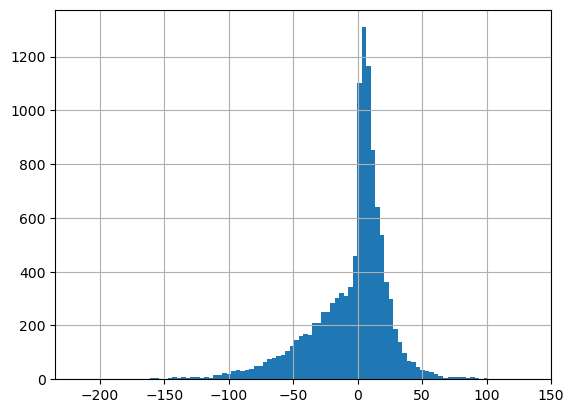

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 1. SETUP AND DATA LOADING ---

# Suppress warnings for cleaner output
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

# Load the dataset
file_path = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_alt_soil_lc_co2.csv"
df = pd.read_csv(file_path)

# Filter for EC flux method and perform initial feature engineering
df = df[df['flux_method'] == 'EC']
df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Define feature columns and categorical features
feature_cols = [
    'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
    'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs',
    'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm',
    'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm',
    'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT',
    'land_cover', 'month' # Categorical features
]
categorical_features = ['land_cover', 'month']

# Drop rows where observed NEE (our validation target) is missing
df = df.dropna(subset=['site_reference', 'nee'])


df['nee'].hist(bins=100)